# Data Analysis for Acquamat project 
## Which are the main metrics for the project by using Geopandas, Folium , Matplotlib, Shapely

Here more info about <a href="https://www.aquamat.org/en/" target='_blank'>Acquamat</a>, a crowdsourced map of drinking water spots scattered throughout all cities around Europe,based in Naples, with the aim of encouraging the use of a public water, reducing the purchase of water plastic bottles.

- Here the imports to script

In [20]:
from typing import ChainMap
from attr import fields
import geopandas
import webbrowser
import folium
import matplotlib.pyplot as plt
from shapely import geometry
from shapely.geometry import geo

- Duction To show the values on the bar 

In [21]:

def showValue(ax):
    for p in ax.patches:
        b = p.get_bbox()       
        ax.annotate(int(b.y1), (((b.x0 + b.x1)/2)-0.1 , b.y1+0.1 ))

- Data repository

In [22]:
quartieri_na = geopandas.read_file("https://maps.nicoladeinnocentis.it/quartieri-na-fontanelle/src/fontanelle_x_quartiere.json")
fontanelle = geopandas.read_file("https://raw.githubusercontent.com/deinic/fontanelle/main/fontanelle.json")
municipalita = geopandas.read_file('municipalita.geojson')

- SPATIAL JOIN data

In [23]:
fontanelle_in_municipalita = fontanelle.sjoin(municipalita,how="inner",predicate="intersects")
pop_area_quartieri=quartieri_na.sjoin(municipalita,how="inner",predicate="intersects")

- Numero Totale di Fontanelle per Municipalità 

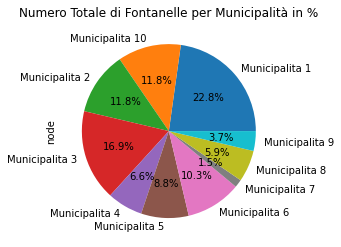

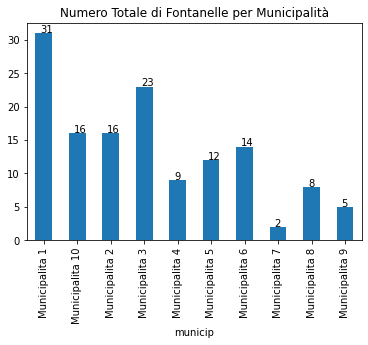

In [24]:
numero_totale_fontanelle_in_municipalita= fontanelle_in_municipalita.dissolve(by='municip' , aggfunc='count')
numero_totale_fontanelle_in_municipalita.plot(kind="pie",y='node',legend=False,autopct='%1.1f%%',title='Numero Totale di Fontanelle per Municipalità in %')
ntfm=numero_totale_fontanelle_in_municipalita.plot(kind="bar",y='node',legend=False,title='Numero Totale di Fontanelle per Municipalità')
showValue(ntfm)

- Numero di Fontanelle FUNZIONANTI per Municipalità Plot

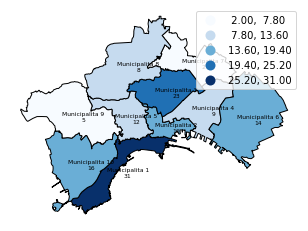

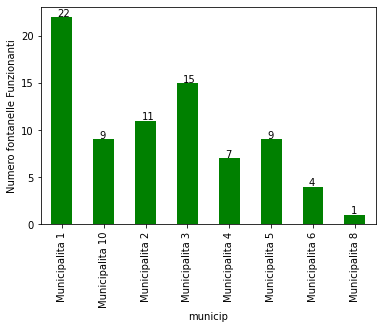

In [25]:
#On the map
municipalita_ft_tot = municipalita.merge(numero_totale_fontanelle_in_municipalita['node'], on='municip')
municipalita_ft_tot_proj=municipalita_ft_tot.to_crs(epsg=32633)
municipalita_ft_tot_proj.plot(column="node",legend="True",scheme="equalinterval",cmap="Blues",edgecolor='black').set_axis_off()
for i in range(len(municipalita_ft_tot_proj)):
    plt.text(municipalita_ft_tot_proj.geometry.centroid.x[i]-780,municipalita_ft_tot_proj.geometry.centroid.y[i]-500,"{}\n{}".format(municipalita_ft_tot_proj.municip[i],municipalita_ft_tot_proj.node[i]),size=6,multialignment='center')

#Numero di Fontanelle FUNZIONANTI per Municipalità Plot
fontanelle_funzionanti_in_municipalita=fontanelle_in_municipalita.loc[fontanelle_in_municipalita['status']=='1']
numero_fontanelle_funzionanti_in_municipalita = fontanelle_funzionanti_in_municipalita.dissolve(by='municip' , aggfunc='count',dropna=False)
nffm = numero_fontanelle_funzionanti_in_municipalita.plot(kind="bar",y='node',color='green',ylabel='Numero fontanelle Funzionanti',legend=False)
showValue(nffm)

- Numero di Fontanelle NON FUNZIONANTI per Municipalità Plot

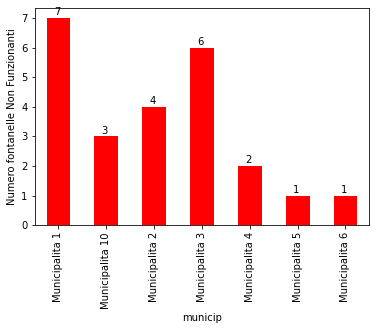

In [26]:
fontanelle_non_funzionanti_in_municipalita=fontanelle_in_municipalita.loc[fontanelle_in_municipalita['status']=='2']
numero_fontanelle_non_funzionanti_in_municipalita = fontanelle_non_funzionanti_in_municipalita.dissolve(by='municip' , aggfunc='count')
nfnfm = numero_fontanelle_non_funzionanti_in_municipalita.plot(kind="bar",y='node',color='red',ylabel='Numero fontanelle Non Funzionanti',legend=False)
showValue(nfnfm)

- Numero residenti per 1 fontanella Plot

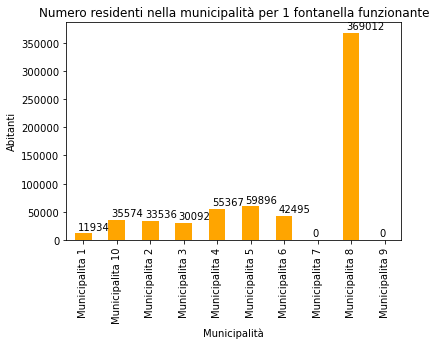

In [27]:
pop_area_quartieri_dissolve =pop_area_quartieri.dissolve(by='municip' , aggfunc='sum')
pop_area_quartieri_dissolve['pop_res'] = pop_area_quartieri_dissolve['popolazione_residente']/numero_fontanelle_funzionanti_in_municipalita['node']
fs = pop_area_quartieri_dissolve.plot(kind="bar", y='pop_res',xlabel='Municipalità' , ylabel = 'Abitanti', color='orange',title='Numero residenti nella municipalità per 1 fontanella funzionante',legend=False)
for p in fs.patches:
    b = p.get_bbox()       
    fs.annotate(int(b.y1), (((b.x0 + b.x1)/2)-0.15 , b.y1+6000 ))

#Show plots
plt.show()

In [112]:
f=municipalita_ft_tot.explore(
    column='node',
    marker_kwds=dict(radius=5, fill=True),
    cmap='Blues',
    scheme="equalinterval",
    highlight=True,
    style_kwds={'stroke':True,'weight':3,'color':'black','fillOpacity':0.8},
)  

mun_json=municipalita_ft_tot.to_json()
#f.save("fontanelle/index.html")
m = folium.Map(location=[40.830891,14.257421], tiles="Stamen Terrain", zoom_start=12)

#webbrowser.open("./fontanelle/index.html",new=2)

folium.Choropleth(
    geo_data=municipalita_ft_tot,
    name="Fontanelle",
    data=municipalita_ft_tot.node,
    #columns=["osm_id","node"],
    fill_color="OrRd",
    key_on='feature.properties.node',
    fill_opacity=0.7,
    line_opacity=0.5,
    highlight=True,
    legend_name="fontanelle",
).add_to(m)

m

